In [2]:
!pip install misdeed

In [3]:
from misdeed.OmicsGenerator import OmicsGenerator
from misdeed.visualization import plot_timecourse, plot_pca
from misdeed.inference import infer_glv_params

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
from matplotlib import cm

import numpy as np
np.random.seed(10 )

# Initialize generator with intervention

In [13]:
# Set global variables
TIME_POINTS = 100
TIME_STEP = 1e-1 # Update abundances 10x/day
NODE_NAMES = ['mgx', 'mbx'] # 2 nodes named 'mgx' and 'mbx'
NODE_SIZES = [15, 15] # Set interaction matrices and growth rates randomly
INTERVENTION_START = 50 # Start intervention at day 50
INTERVENTION_END = 100 # End intervention at day 100

# Get names
NAMES_MGX = [f"mgx_{i}" for i in range(NODE_SIZES[0])]
NAMES_MBX = [f"mbx_{i}" for i in range(NODE_SIZES[1])]

In [14]:
# Initialize generator:
gen = OmicsGenerator(
    time_points=TIME_POINTS,
    node_names=NODE_NAMES,
    node_sizes=NODE_SIZES,
    init_full=True
)

# Add intervention:
gen.add_intervention(
    name='int1', # intervention name
    node_name='mgx', # apply to 'mgx' node
    vector=10*np.random.rand(15), # set intervention response vector randomly
    start=INTERVENTION_START, # start at t=50
    end=INTERVENTION_END # go to end
)

Node 'mgx' initialized
Node 'mbx' initialized
Interaction 'mgx->mgx' added
set m:(mgx)->(mgx):   0:15    0:15
Interaction 'mgx->mbx' added
set m:(mgx)->(mbx):   0:15    15:30
Interaction 'mbx->mgx' added
set m:(mbx)->(mgx):   15:30    0:15
Interaction 'mbx->mbx' added
set m:(mbx)->(mbx):   15:30    15:30
Added x0 vector to node mgx
Added growth rates to node mgx
Added x0 vector to node mbx
Added growth rates to node mbx
Initialized
Intervention 'int1' added


# Single timecourse

In [15]:
# Run generator and plot:
z1, x1, y1 = gen.generate(dt=TIME_STEP)
plot_timecourse(df=y1['mgx'])
plt.vlines(INTERVENTION_START, 0, 1)


TypeError: plot_timecourse() got an unexpected keyword argument 'names'

# Multiple timecourses

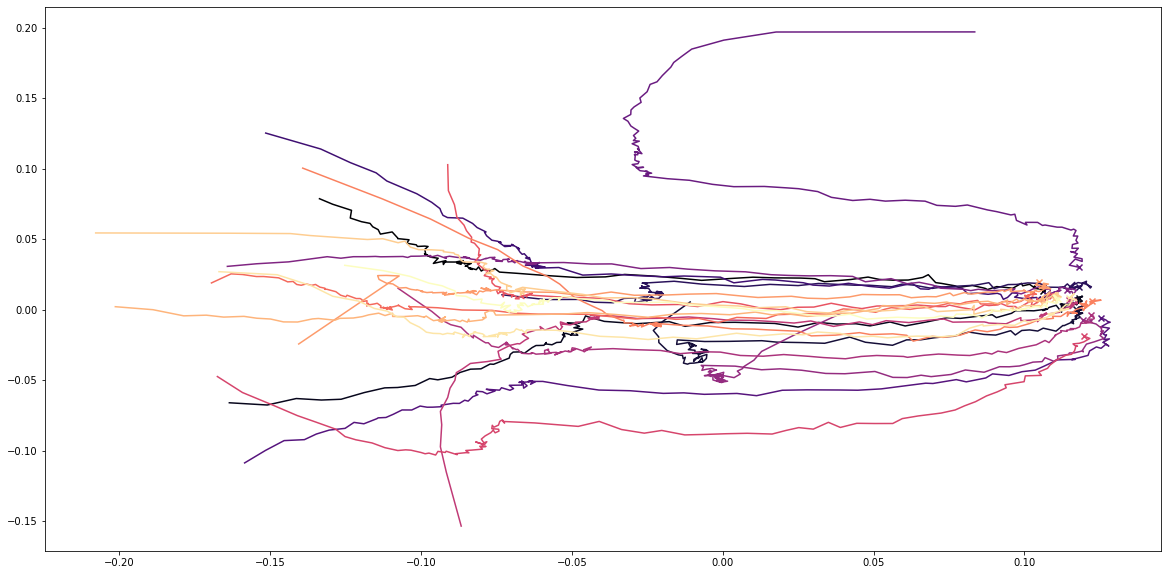

In [10]:
# Run multi-generator and plot:
z2, x2, y2 = gen.generate_multiple(n=20)
plot_pca(
    trajectories=[y2], 
    node_name='mgx'
)


# Case-control

Intervention 'CASE' added


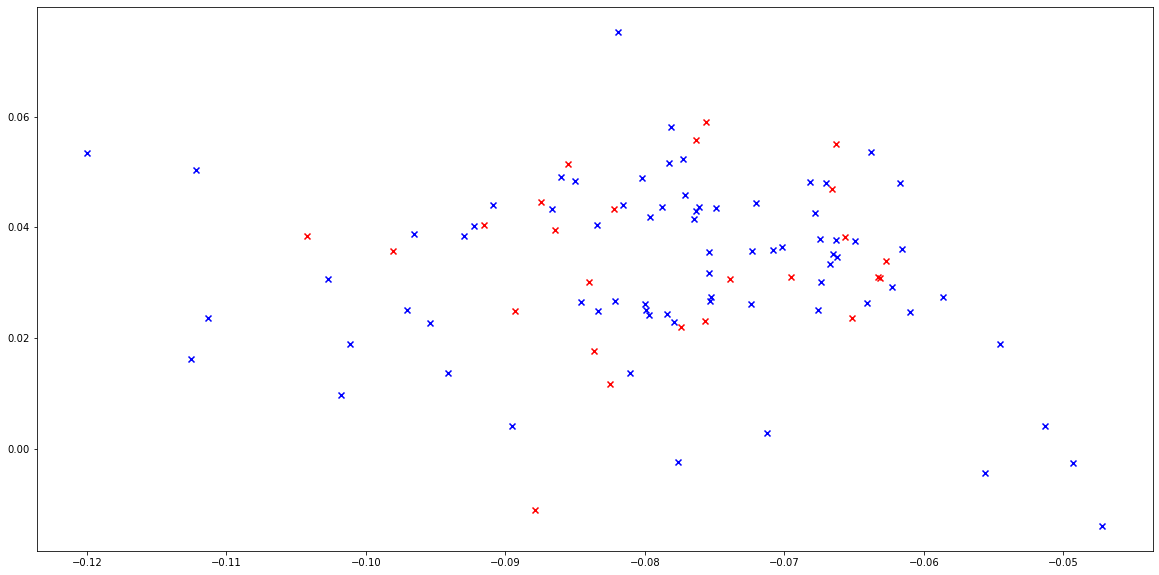

In [6]:
# Run case-control and plot:
z3_control, x3_control, y3_control, z3_case, x3_case, y3_case = gen.case_control(
    participants=100,
    case_frac=.75,
    node_name='mgx',
    effect_size=1,
    dt=TIME_STEP
)
plot_pca(
    trajectories=[y3_control, y3_case], 
    node_name='mgx', 
    colors=['red', 'blue'], 
    plot_trajectories=False
)


# Using learned interaction matrices

Node 'mgx' initialized
Interaction 'mgx->mgx' added
set m:(mgx)->(mgx):   0:8    0:8
Added x0 vector to node mgx
Added growth rates to node mgx
Initialized
Intervention 'int1' added
Node 'mgx' initialized
Initialized
Interaction 'M' added
Intervention 'int1' added
Added growth rates to node mgx
Added x0 vector to node mgx


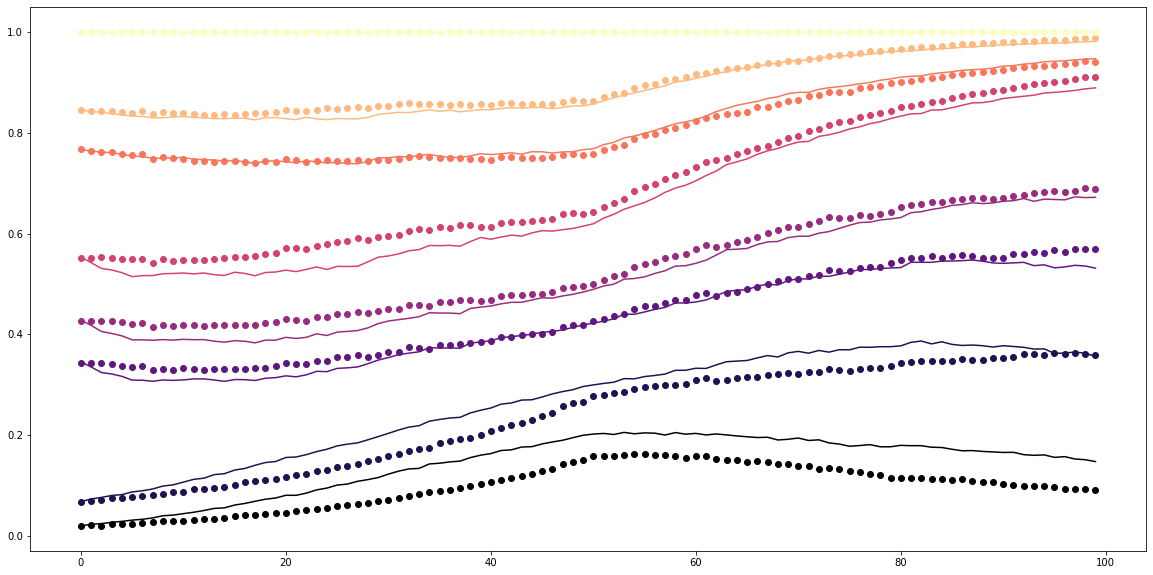

In [30]:
# New global variables:
INFER_NODE_NAMES = ['mgx']
NODE_SIZE = 8
INFER_NODE_SIZES = [NODE_SIZE]

# Run case-control and plot:
gen4 = OmicsGenerator(
    node_names=INFER_NODE_NAMES,
    node_sizes=INFER_NODE_SIZES,
    init_full=True # set interaction matrices and growth rates randomly
)

# Add intervention:
gen4.add_intervention(
    name='int1', # intervention name
    node_name='mgx', # apply to 'mgx' node
    vector=10*np.random.rand(NODE_SIZE), # set intervention response vector randomly
    start=INTERVENTION_START, # start at t=50
    end=INTERVENTION_END # go to end
)

# Generate training data
z4, x4, y4 = gen4.generate(dt=TIME_STEP)

# Infer gLV parameters
M, u, E = infer_glv_params(
    abundances=z4['mgx'], # use (latent) absolute abundances
    interventions=gen4.get('int1').U, # assume intervention indicator is known
    interaction_reg=100,   # L1 penalty for interaction matrix
    growth_reg=0, # L1 penalty for growth rates
    intervention_reg=0, # L1 penalty for intervention responses
    dt=TIME_STEP # same time-step as generator
)

# Build inferred generator
gen4_inferred = OmicsGenerator(
    node_names=INFER_NODE_NAMES, 
    node_sizes=INFER_NODE_SIZES
)
gen4_inferred.add_interaction(
    name='M',
    outbound_node_name='mgx',
    inbound_node_name='mgx',
    matrix=M
)
gen4_inferred.add_intervention(
    name='int1',
    node_name='mgx',
    vector=E.reshape(-1),
    start=INTERVENTION_START,
    end=INTERVENTION_END
)
gen4_inferred.set_initial_value(
    node_name='mgx',
    values=u.reshape(-1),
    growth_rate=True
)
gen4_inferred.set_initial_value(
    node_name='mgx',
#     values=gen4.get('mgx').initial_value # same init. abundances as gen 1
    values=y4['mgx'][0],
)

z4_inferred, x4_inferred, y4_inferred = gen4_inferred.generate(dt=TIME_STEP)

# Plot both trajectories
colors = cm.get_cmap('magma', NODE_SIZE)(range(NODE_SIZE))

for i in range(NODE_SIZE):
#     plt.plot(np.cumsum(z4_inferred['mgx'], axis=1)[:,i], alpha=0.5, c=colors[i])
    plt.scatter(np.arange(100), np.cumsum(y4_inferred['mgx'], axis=1)[:,i], color=colors[i])
    plt.plot(np.cumsum(y4['mgx'], axis=1)[:,i], c=colors[i])